In [10]:
import os
from tqdm import tqdm
import cv2 as cv
import numpy as np
from keras.utils import to_categorical

root_path = r'/kaggle/input/animal-classification/Data/'

class_names = sorted(os.listdir(root_path))
print(class_names)

def load_data(root_path, class_names, num_images_per_folder=200):
    data = []
    labels = []

    for name in class_names:
        folderpath = os.path.join(root_path, name)
        count = 0  # Variable to keep track of the number of images loaded for each class
        for image_name in tqdm(os.listdir(folderpath)):
            if count >= num_images_per_folder:
                break  # Stop loading images if the desired number is reached
            img = cv.imread(os.path.join(folderpath, image_name))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (224, 224))
            data.append(img)
            labels.append(class_names.index(name))
            count += 1

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

data, labels = load_data(root_path, class_names, num_images_per_folder=1000)
labels = to_categorical(labels)

['Buffalo', 'Elephant', 'Rhino', 'Zebra']


100%|██████████| 1000/1000 [00:04<00:00, 216.13it/s]


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state = 42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow(x_test, y_test, batch_size=32)

In [12]:
BATCH_SIZE = 32

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(4, activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(x_test) // BATCH_SIZE,
    callbacks=[early_stopping]
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 32)       

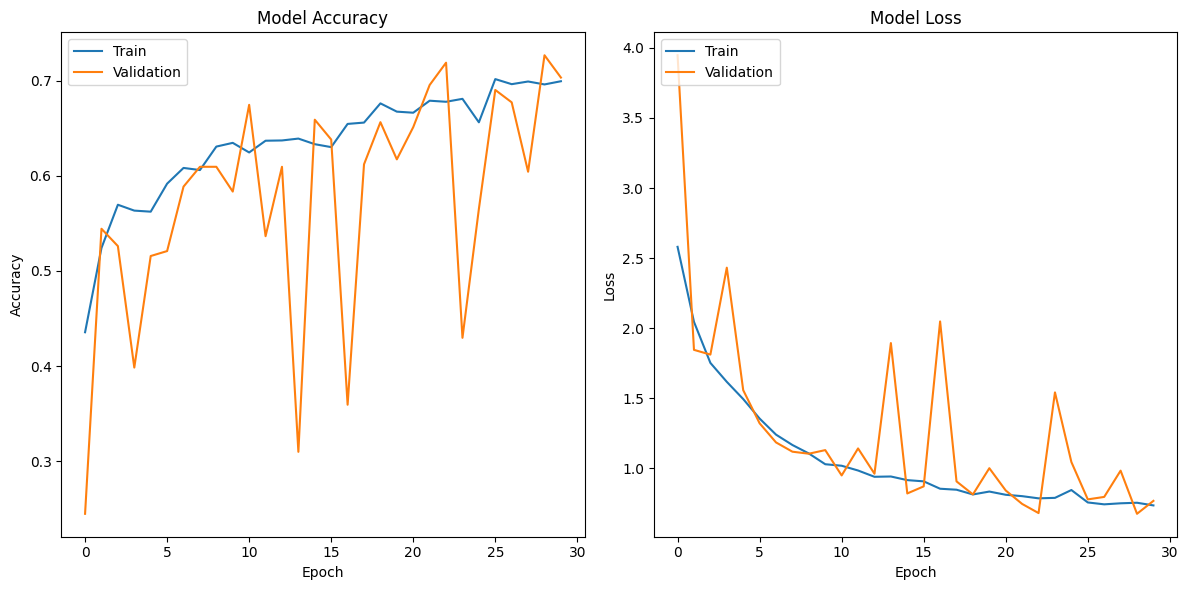

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
model.save("featureextraction_CNN.h5")
model.save('feature_extraction_CNN.keras')